In [1]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

plt.ion()
sc.settings.verbosity = 3
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.22.1 scipy==1.7.3 pandas==1.4.0 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


In [2]:
adata = sc.read_h5ad("./data/scgen/scGen_datasets/train_study.h5ad")
bdata = sc.read_h5ad("./data/scgen/scGen_datasets/valid_study.h5ad")

enc_labels = LabelEncoder()
labels = enc_labels.fit_transform( adata.obs["cell_type"],)
labels = F.one_hot(torch.tensor(labels)).float()
enc_conds = LabelEncoder()
conditions = enc_conds.fit_transform(adata.obs["condition"],)
conditions = F.one_hot(torch.tensor(conditions)).float()
data = torch.tensor(adata.X.toarray())

test_enc_labels = LabelEncoder()
test_labels = test_enc_labels.fit_transform( bdata.obs["cell_type"],)
test_labels = F.one_hot(torch.tensor(test_labels)).float()
test_enc_conds = LabelEncoder()
test_conditions = test_enc_conds.fit_transform(bdata.obs["condition"],)
test_conditions = F.one_hot(torch.tensor(test_conditions)).float()
test_data = torch.tensor(bdata.X.toarray())


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [29]:
adata.X = adata.X.toarray()
bdata.X = bdata.X.toarray()

In [3]:
labeledSubset = ut.randomSubset(s=len(adata), r=0.45)
labeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data[labeledSubset],
                labels[labeledSubset],
                conditions[labeledSubset],
                ],),
            batch_size=128,
            shuffle=True,
            )
unlabeled_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data[~labeledSubset],
                labels[~labeledSubset],
                conditions[~labeledSubset],
                ],),
            batch_size=128,
            shuffle=True,
            )
test_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [test_data,
                test_labels,
                test_conditions,
                ],),
            batch_size=128,
            shuffle=True,
            )
train_loader = torch.utils.data.DataLoader(
        dataset = ut.SynteticDataSetV2(
            [data,
                labels,
                conditions,
                ],),
            batch_size=128,
            shuffle=True,
            )

x,y,c = train_loader.__iter__().next()

In [5]:
model = Mb0.VAE_Dirichlet_GMM_TypeB1602xzCv2(
        nx=adata.n_vars,
        nz=10,
        nw=10,
        nclasses=labels.shape[1],
        concentration=1e0,
        dropout=0.1,
        bn=True,
        reclosstype="mse",
        restrict_w=True,
        restrict_z=True,
        nc1=conditions.shape[1],
        learned_prior=False,
        #learned_prior=True,
        )
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_Dirichlet_GMM_TypeB1602xzCv2'>


In [6]:
Train.trainSemiSuperLoopCond(
        model,
        labeled_loader,
        unlabeled_loader,
        test_loader,
        num_epochs=40,
        lrs = [1e-5,1e-4,1e-3,1e-3,1e-3,1e-4,1e-5,],
        wt=1e-4,
        do_unlabeled=True,
        do_validation=True,
        report_interval=45,
        test_accuracy=True,
        )

epoch 0
labeled phase
rec: 1351.7783203125
loss_z: 17.83212661743164
loss_w: 5.751751899719238
loss_cluster: -0.3693813681602478
loss_d: 5.931488513946533
loss_y_alt: 3.375894546508789
loss_y_alt2: 2.5941128730773926
total_loss: 1387.263671875
num_clusters: 4

[ 2.  1. -1.  1.  2.  5.  1.] 
 0.14050546105340625 
 [ 0.26923077  0.33333333 -1.          0.4         0.36986301  0.27777778
  0.33333333]
0.3464566929133858 

unlabeled phase
rec: 1001.7578125
loss_z: 14.055673599243164
loss_w: 5.139344215393066
loss_cluster: -0.4555966854095459
loss_d: 4.117163181304932
loss_y_alt: 1.3786283731460571
loss_y_alt2: 0
total_loss: 1026.4486083984375
num_clusters: 5

eval phase
rec: 683.88232421875
loss_z: 8.482389450073242
loss_w: 3.4105491638183594
loss_cluster: -0.6077249050140381
loss_d: 2.3997201919555664
loss_y_alt: 1.4753220081329346
loss_y_alt2: 0
total_loss: 699.6502685546875
num_clusters: 5
ce loss: -0.9356382489204407

done training
epoch 0
labeled phase
rec: 239.53627014160156
loss_z: 

In [86]:
ut.saveModelParameters(
        model,
        "./results/Kang_ss_gauss_cond_prior" + str(datetime.timestamp(datetime.now())) + "model_params.pt",
        method="json",
        )

torch.save(
        model.state_dict(),
        "./results/Kang_ss_gauu_cond_prior" + str(datetime.timestamp(datetime.now())) + "model_state.pt",
        )

In [7]:
model.cpu()
model.eval()
output = model(test_data, cond1=test_conditions)

# not quite correct b/c it doesn't uses the conditional info
r,p,s = ut.estimateClusterImpurityLoop(model, test_data, test_labels, "cuda", )
print(p, "\n", r.mean(), "\n", r)


[0. 1. 2. 3. 4. 5. 6.] 
 0.8446733528640612 
 [0.93303571 0.784375   0.9648855  0.64102564 0.7962963  0.87439614
 0.91869919]
0.8765
tensor(0.8685)


In [8]:
print((r*s).sum() / s.sum())


0.8765


In [9]:

print(
    torch.sum(output["q_y"].detach().argmax(-1) == test_labels.argmax(-1)) / len(bdata)
)


tensor(0.8685)


In [11]:
bdata.obsm["mu_w"] = output["mu_w"].detach().numpy()
bdata.obsm["w"] = output["w"].detach().numpy()
bdata.obsm["z"] = output["mu_z"].detach().numpy()
bdata.obs["predict"] = test_enc_labels.inverse_transform(
    output["q_y"].detach().argmax(-1).numpy()
)
bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
        test_labels.argmax(-1))


In [14]:
#sc.pp.neighbors(bdata,use_rep="z")
sc.pp.neighbors(bdata,use_rep="mu_w")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


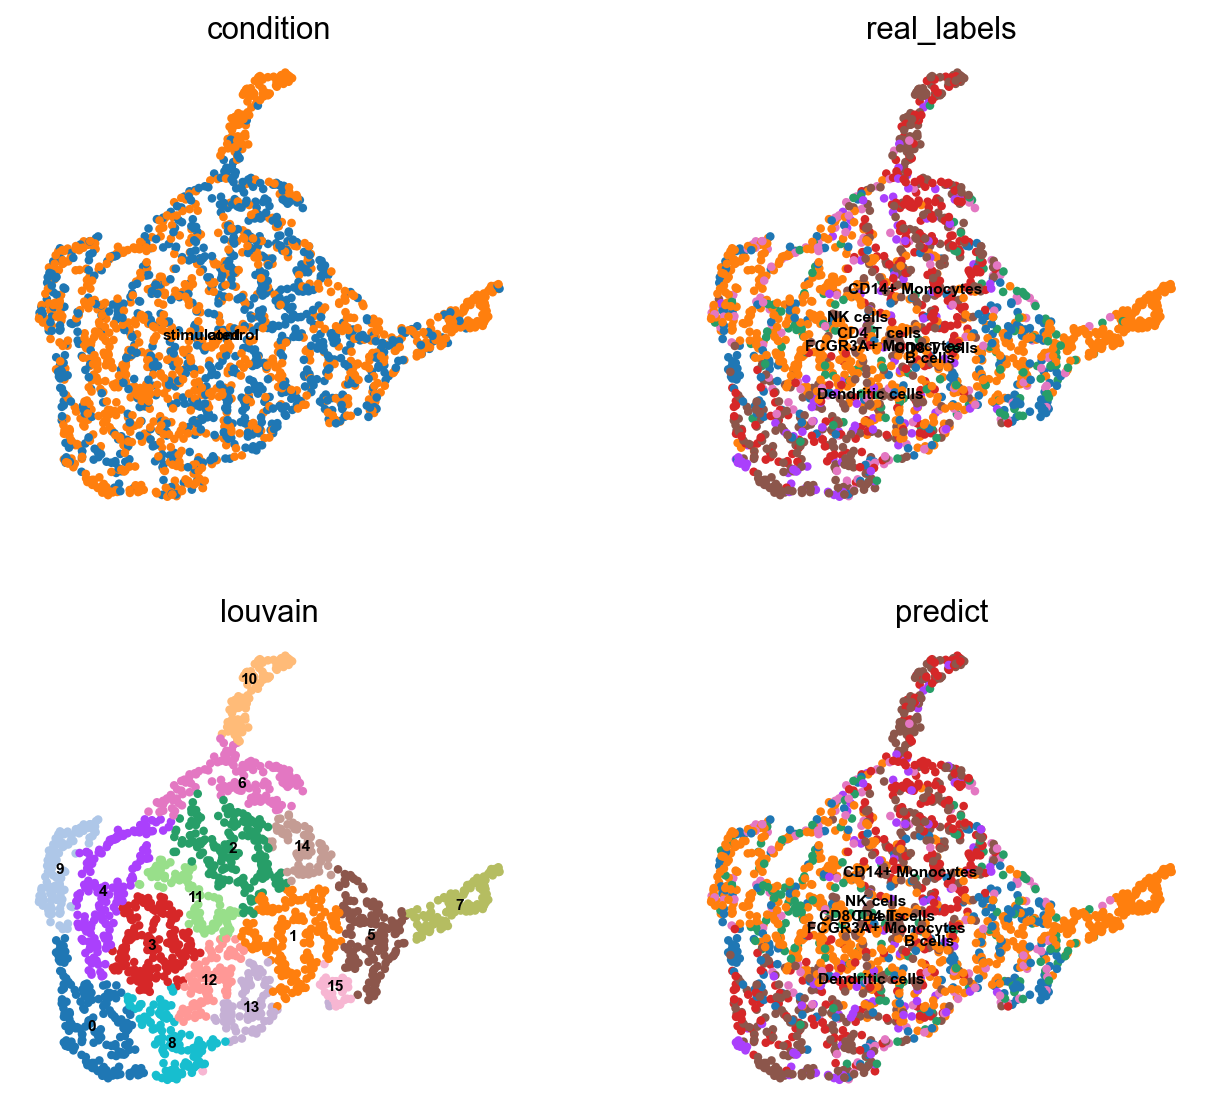

In [15]:
sc.pl.umap(bdata, color=["condition", "real_labels", "louvain", "predict"], 
        frameon=False,
        legend_loc='on data',
        legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [16]:
sc.pp.neighbors(bdata,use_rep="w")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


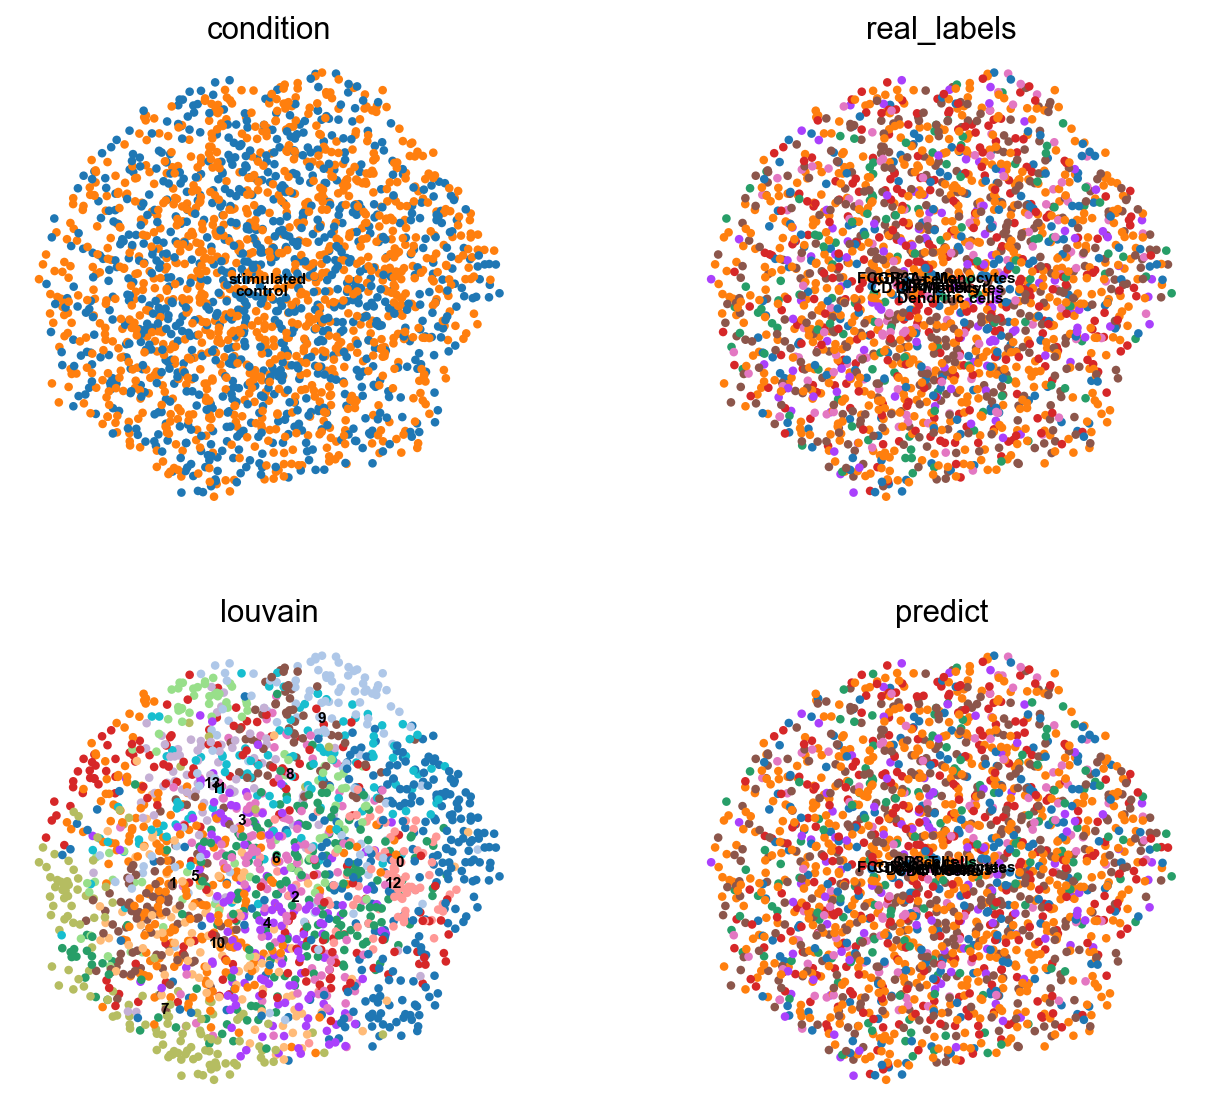

In [17]:
sc.pl.umap(bdata, color=["condition", "real_labels", "louvain", "predict"], 
        frameon=False,
        legend_loc='on data',
        legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )

In [18]:
sc.pp.neighbors(bdata,use_rep="z")
sc.tl.umap(bdata, )
sc.tl.louvain(bdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


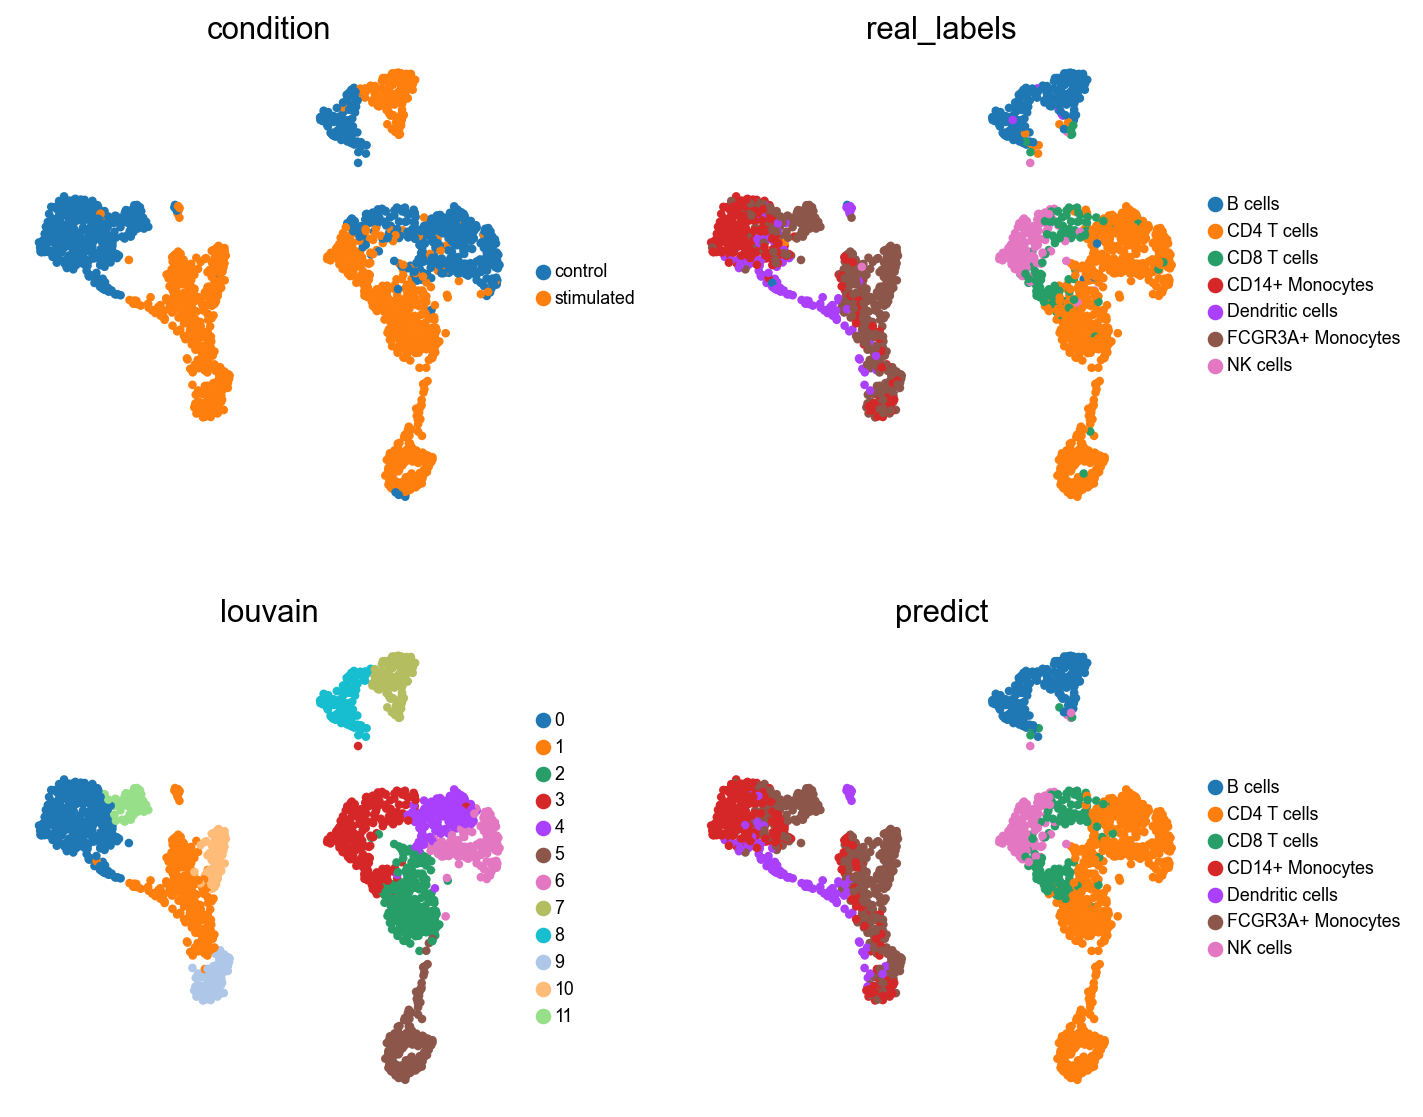

In [21]:
sc.pl.umap(bdata, color=["condition", "real_labels", "louvain", "predict"], 
        frameon=False,
        #legend_loc='on data',
        legend_fontsize=8,
        ncols=2,
        #color_map="magma",
        )

In [23]:
# set 'control' marker:
ctrlMaerker = bdata.obs["condition"] == "control"
# set B cells marker:
bCellMarker = bdata.obs["real_labels"] == "B cells"

In [30]:
cdata = bdata[ctrlMaerker & bCellMarker].copy()
cdata.obs

cell_type condition  mt_frac  n_counts  n_genes  \
index                                                                        
AGGTACACGGATCT-1-control-0   B cells   control      0.0    1721.0      719   
CTATGTTGTGGTCA-1-control-0   B cells   control      0.0    1959.0      753   
GAAGCTTGATGTGC-1-control-0   B cells   control      0.0    2407.0      896   
GACGGCACAATCGC-1-control-0   B cells   control      0.0    1237.0      559   
AGGTGTTGTGTTCT-1-control-0   B cells   control      0.0    1636.0      746   
...                              ...       ...      ...       ...      ...   
CACATACTCTGCTC-1-control-0   B cells   control      0.0    1260.0      588   
CGTCCATGTCCCGT-1-control-0   B cells   control      0.0    1121.0      528   
ATGATATGCGAGAG-1-control-0   B cells   control      0.0    2849.0      864   
ATCACACTGTTGCA-1-control-0   B cells   control      0.0    1571.0      719   
ACACGAACGCTGTA-1-control-0   B cells   control      0.0    2466.0      986   

                            percent_mito       study      predict real_labels  \
index                                                                           
AGGTACACGGATCT-1-control-0           NaN  Kang et al      B cells     B cells   
CTATGTTGTGGTCA-1-control-0           NaN  Kang et al      B cells     B cells   
GAAGCTTGATGTGC-1-control-0           NaN  Kang et al      B cells     B cells   
GACGGCACAATCGC-1-control-0           NaN  Kang et al      B cells     B cells   
AGGTGTTGTGTTCT-1-control-0           NaN  Kang et al      B cells     B cells   
...                                  ...         ...          ...         ...   
CACATACTCTGCTC-1-control-0           NaN  Kang et al      B cells     B cells   
CGTCCATGTCCCGT-1-control-0           NaN  Kang et al  CD8 T cells     B cells   
ATGATATGCGAGAG-1-control-0           NaN  Kang et al      B cells     B cells   
ATCACACTGTTGCA-1-control-0           NaN  Kang et al      B cells     B cells   
ACACGAACGCTGTA-1-control-0           NaN  Kang et al      B cells     B cells   

                           louvain  
index                               
AGGTACACGGATCT-1-control-0       8  
CTATGTTGTGGTCA-1-control-0       8  
GAAGCTTGATGTGC-1-control-0       8  
GACGGCACAATCGC-1-control-0       8  
AGGTGTTGTGTTCT-1-control-0       8  
...                            ...  
CACATACTCTGCTC-1-control-0       8  
CGTCCATGTCCCGT-1-control-0       4  
ATGATATGCGAGAG-1-control-0       8  
ATCACACTGTTGCA-1-control-0       8  
ACACGAACGCTGTA-1-control-0       8  

[94 rows x 10 columns]

In [37]:
#test_data[ctrlMaerker & bCellMarker]
#test_labels[ctrlMaerker & bCellMarker]
#test_conditions[ctrlMaerker & bCellMarker]
# simulate stimulation of control B cells:
model.cpu()
model.eval()
simOutput = model(
    input=test_data[ctrlMaerker & bCellMarker],
    y=test_labels[ctrlMaerker & bCellMarker],
    cond1=test_conditions[ctrlMaerker & bCellMarker],
)

In [42]:
cdata.X = simOutput['rec'].detach().abs().numpy()
#simOutput['rec'].detach().max()
#simOutput['rec'].detach().min()

In [58]:
cdata.obsm["z"] = simOutput["mu_z"].detach().numpy()
cdata.obsm["mu_w"] = simOutput["mu_w"].detach().numpy()
cdata.obsm["w"] = simOutput["w"].detach().numpy()
cdata.obsm

#bdata.obs["predict"] = test_enc_labels.inverse_transform(
#    output["q_y"].detach().argmax(-1).numpy()
#)
#bdata.obs["real_labels"] = test_enc_labels.inverse_transform(
#        test_labels.argmax(-1))

AxisArrays with keys: X_pca, X_umap, X_tsne, w, z, mu_w

In [43]:
bCellsControlData = test_data[ctrlMaerker & bCellMarker].detach()
bCellsStimData = test_data[(~ctrlMaerker) & bCellMarker].detach()
bCellSimStimData = simOutput['rec'].detach().abs() 

In [44]:
stats.linregress(bCellsControlData.mean(0), bCellSimStimData.mean(0))

LinregressResult(slope=0.9782029902752136, intercept=0.002904839404245213, rvalue=0.9922260617700769, pvalue=0.0, stderr=0.0014666322762676117, intercept_stderr=0.0002643835018106208)

In [46]:
stats.linregress(bCellsControlData.mean(0), bCellsStimData.mean(0))

LinregressResult(slope=0.9318769787765108, intercept=0.002876564465809993, rvalue=0.8931695007474775, pvalue=0.0, stderr=0.0056089311346659175, intercept_stderr=0.0010110979274037281)

In [48]:
# so the simulation of the stimulation on the control cells has higher correlation to the stimulated cells than the original input
# as expected

In [66]:
cdata.obs["sim"] = "simulated"
#bdata.obs["sim"] = "not simulated"
bdata.obs["sim"] = bdata.obs["condition"].copy()

In [67]:
xdata = ad.concat([bdata, cdata], label="set", join="inner",)
#xdata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [68]:
#xdata.obs_names_make_unique?
xdata.var_names_make_unique()
xdata.obs_names_make_unique()

In [69]:
sc.pp.neighbors(xdata,use_rep="z")
sc.tl.umap(xdata, )
sc.tl.louvain(xdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed i

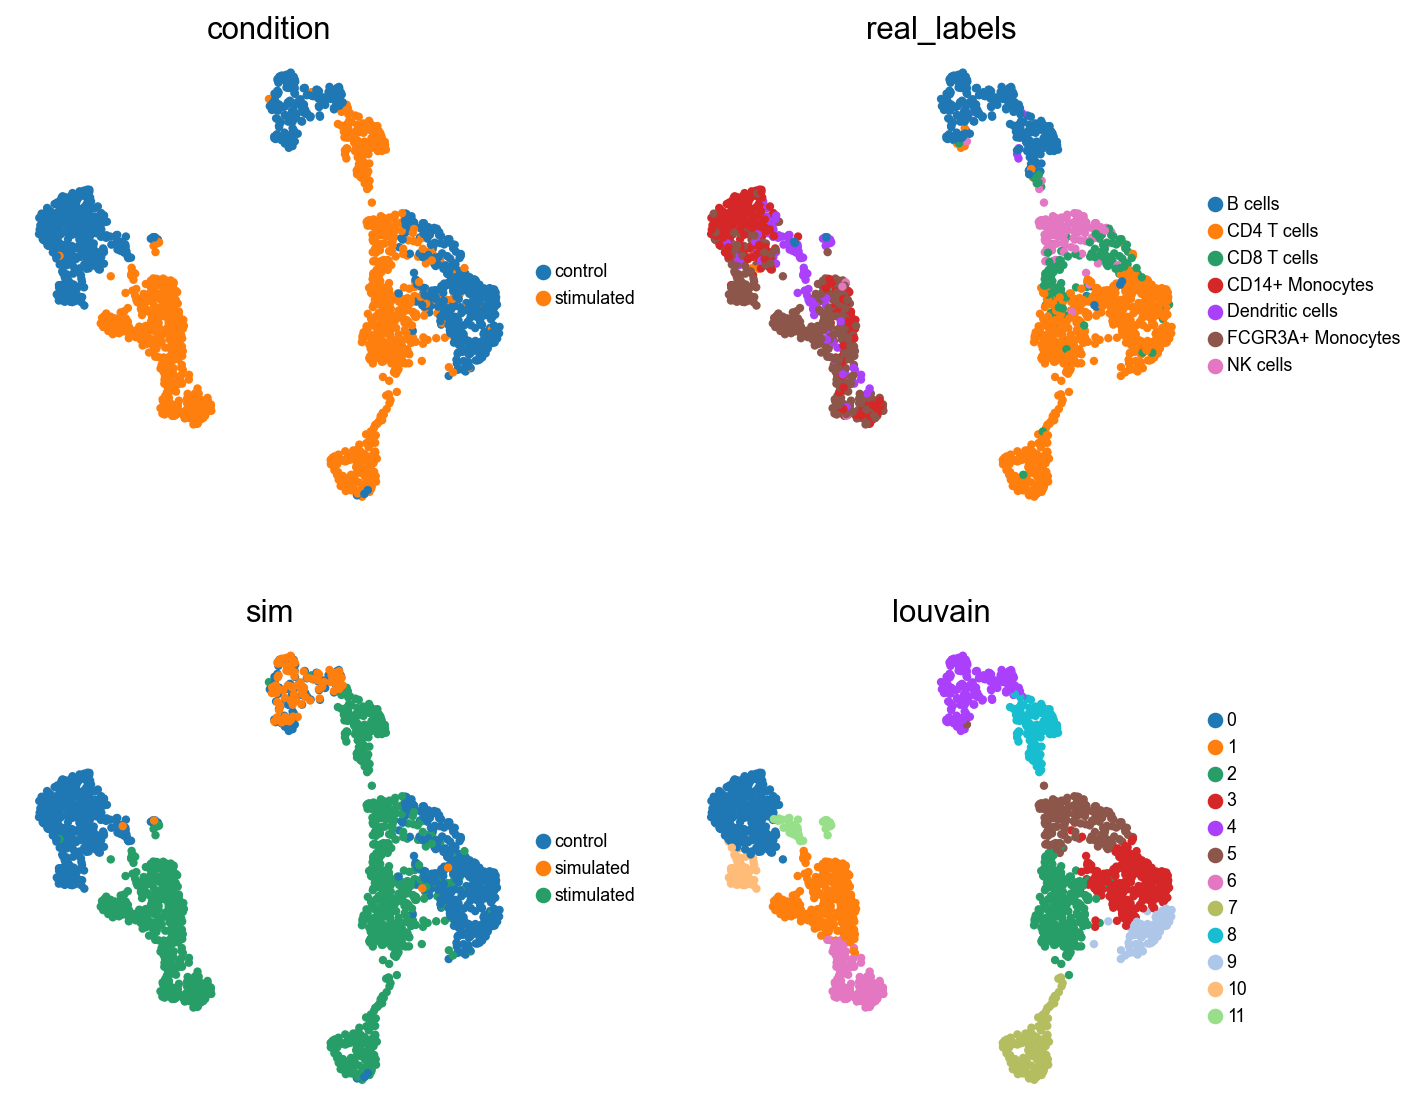

In [70]:
sc.pl.umap(xdata,
           color=[
               "condition",
               "real_labels",
               "sim",
               "louvain",
               ], 
        frameon=False,
        #legend_loc='on data',
        legend_fontsize=8,
        ncols=2,
        #color_map="magma",
        )


In [71]:
sc.pp.pca(xdata,)
sc.pp.neighbors(xdata,)
sc.tl.umap(xdata,)
sc.tl.louvain(xdata,)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


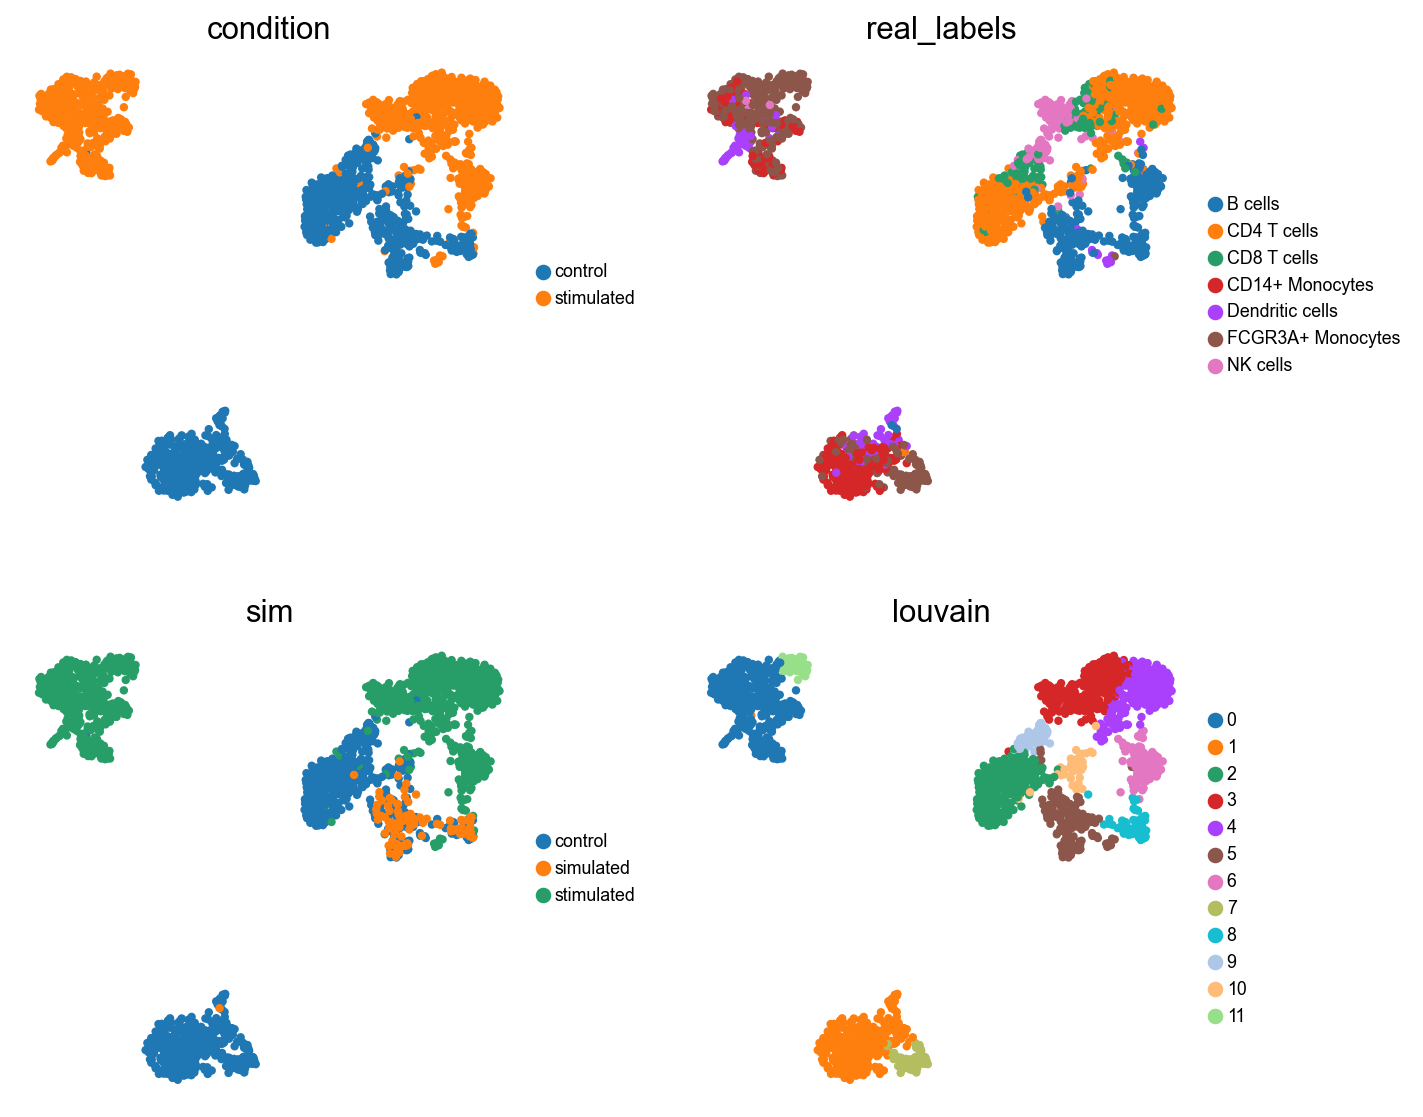

In [72]:
sc.pl.umap(xdata,
           color=[
               "condition",
               "real_labels",
               "sim",
               "louvain",
               ], 
        frameon=False,
        #legend_loc='on data',
        legend_fontsize=8,
        ncols=2,
        #color_map="magma",
        )


In [65]:
cdata.obs

cell_type condition  mt_frac  n_counts  n_genes  \
index                                                                        
AGGTACACGGATCT-1-control-0   B cells   control      0.0    1721.0      719   
CTATGTTGTGGTCA-1-control-0   B cells   control      0.0    1959.0      753   
GAAGCTTGATGTGC-1-control-0   B cells   control      0.0    2407.0      896   
GACGGCACAATCGC-1-control-0   B cells   control      0.0    1237.0      559   
AGGTGTTGTGTTCT-1-control-0   B cells   control      0.0    1636.0      746   
...                              ...       ...      ...       ...      ...   
CACATACTCTGCTC-1-control-0   B cells   control      0.0    1260.0      588   
CGTCCATGTCCCGT-1-control-0   B cells   control      0.0    1121.0      528   
ATGATATGCGAGAG-1-control-0   B cells   control      0.0    2849.0      864   
ATCACACTGTTGCA-1-control-0   B cells   control      0.0    1571.0      719   
ACACGAACGCTGTA-1-control-0   B cells   control      0.0    2466.0      986   

                            percent_mito       study      predict real_labels  \
index                                                                           
AGGTACACGGATCT-1-control-0           NaN  Kang et al      B cells     B cells   
CTATGTTGTGGTCA-1-control-0           NaN  Kang et al      B cells     B cells   
GAAGCTTGATGTGC-1-control-0           NaN  Kang et al      B cells     B cells   
GACGGCACAATCGC-1-control-0           NaN  Kang et al      B cells     B cells   
AGGTGTTGTGTTCT-1-control-0           NaN  Kang et al      B cells     B cells   
...                                  ...         ...          ...         ...   
CACATACTCTGCTC-1-control-0           NaN  Kang et al      B cells     B cells   
CGTCCATGTCCCGT-1-control-0           NaN  Kang et al  CD8 T cells     B cells   
ATGATATGCGAGAG-1-control-0           NaN  Kang et al      B cells     B cells   
ATCACACTGTTGCA-1-control-0           NaN  Kang et al      B cells     B cells   
ACACGAACGCTGTA-1-control-0           NaN  Kang et al      B cells     B cells   

                           louvain        sim  
index                                          
AGGTACACGGATCT-1-control-0       8  simulated  
CTATGTTGTGGTCA-1-control-0       8  simulated  
GAAGCTTGATGTGC-1-control-0       8  simulated  
GACGGCACAATCGC-1-control-0       8  simulated  
AGGTGTTGTGTTCT-1-control-0       8  simulated  
...                            ...        ...  
CACATACTCTGCTC-1-control-0       8  simulated  
CGTCCATGTCCCGT-1-control-0       4  simulated  
ATGATATGCGAGAG-1-control-0       8  simulated  
ATCACACTGTTGCA-1-control-0       8  simulated  
ACACGAACGCTGTA-1-control-0       8  simulated  

[94 rows x 11 columns]

In [73]:
model.cpu()
model.eval()
simOutput = model(
    input=test_data[ctrlMaerker & bCellMarker],
    y=test_labels[ctrlMaerker & bCellMarker],
    cond1=1-test_conditions[ctrlMaerker & bCellMarker],
)


In [74]:
cdata.X = simOutput['rec'].detach().abs().numpy()
cdata.obsm["z"] = simOutput["mu_z"].detach().numpy()
cdata.obsm["mu_w"] = simOutput["mu_w"].detach().numpy()
cdata.obsm["w"] = simOutput["w"].detach().numpy()
cdata.obs["sim"] = "simulated"
#bdata.obs["sim"] = "not simulated"
bdata.obs["sim"] = bdata.obs["condition"].copy()

In [75]:
xdata = ad.concat([bdata, cdata], label="set", join="inner",)
xdata.var_names_make_unique()
xdata.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [76]:
sc.pp.neighbors(xdata,use_rep="z")
sc.tl.umap(xdata, )
sc.tl.louvain(xdata,)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed i

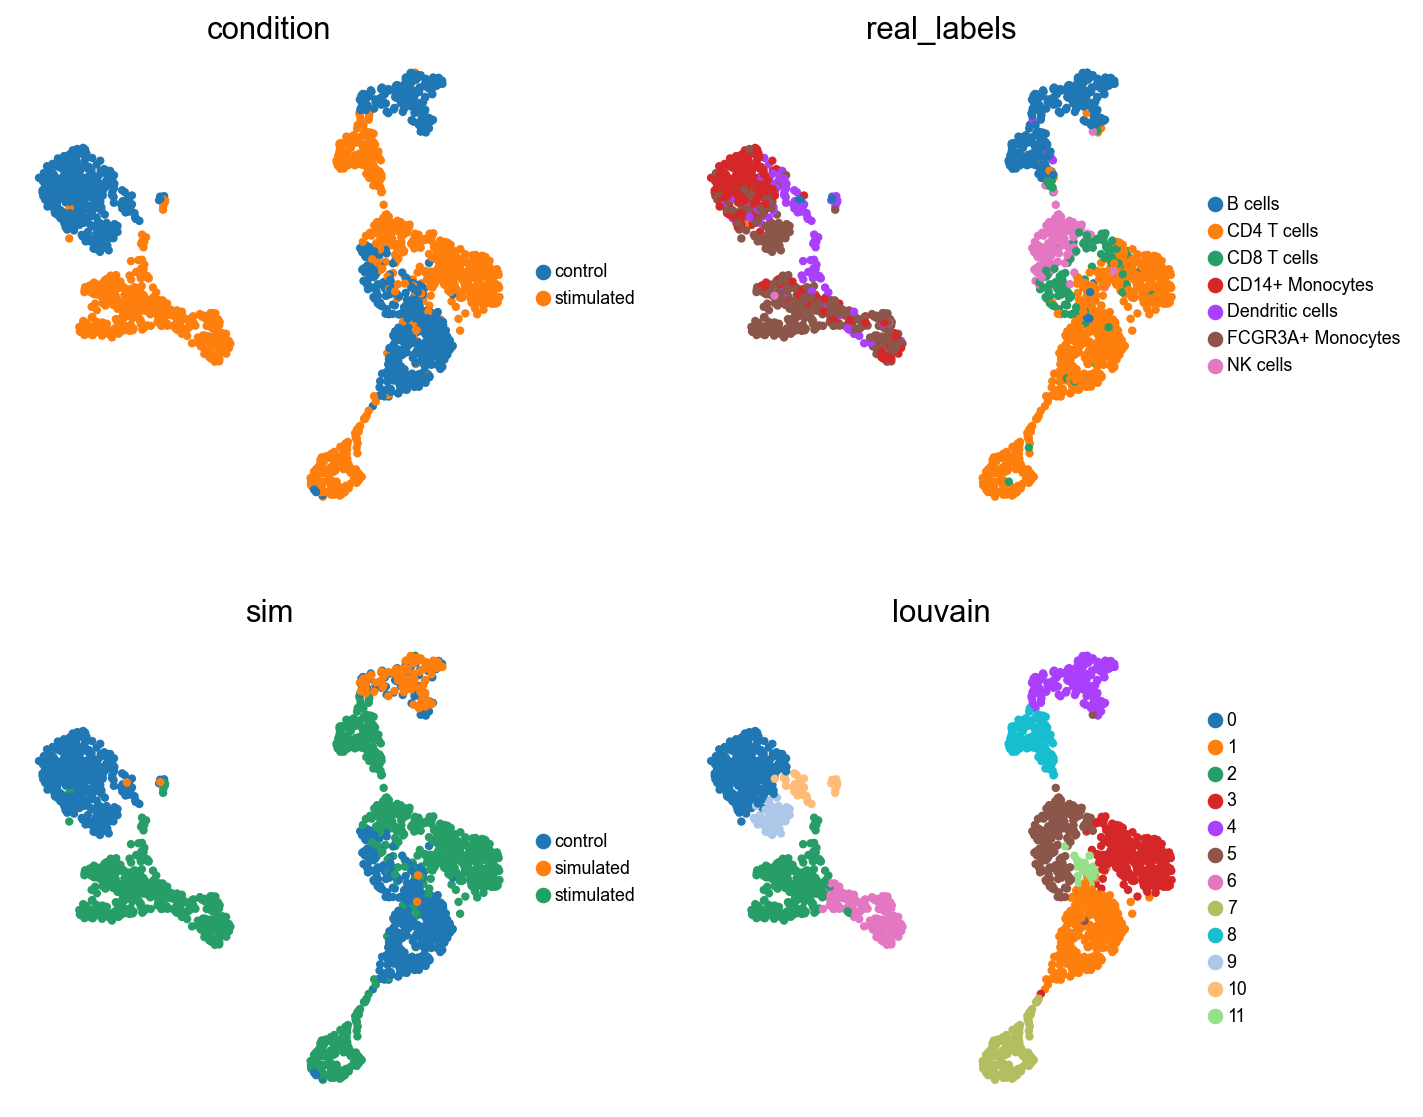

In [77]:
sc.pl.umap(xdata,
           color=[
               "condition",
               "real_labels",
               "sim",
               "louvain",
               ], 
        frameon=False,
        #legend_loc='on data',
        legend_fontsize=8,
        ncols=2,
        #color_map="magma",
        )

In [78]:
sc.pp.pca(xdata,)
sc.pp.neighbors(xdata,)
sc.tl.umap(xdata,)
sc.tl.louvain(xdata,)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


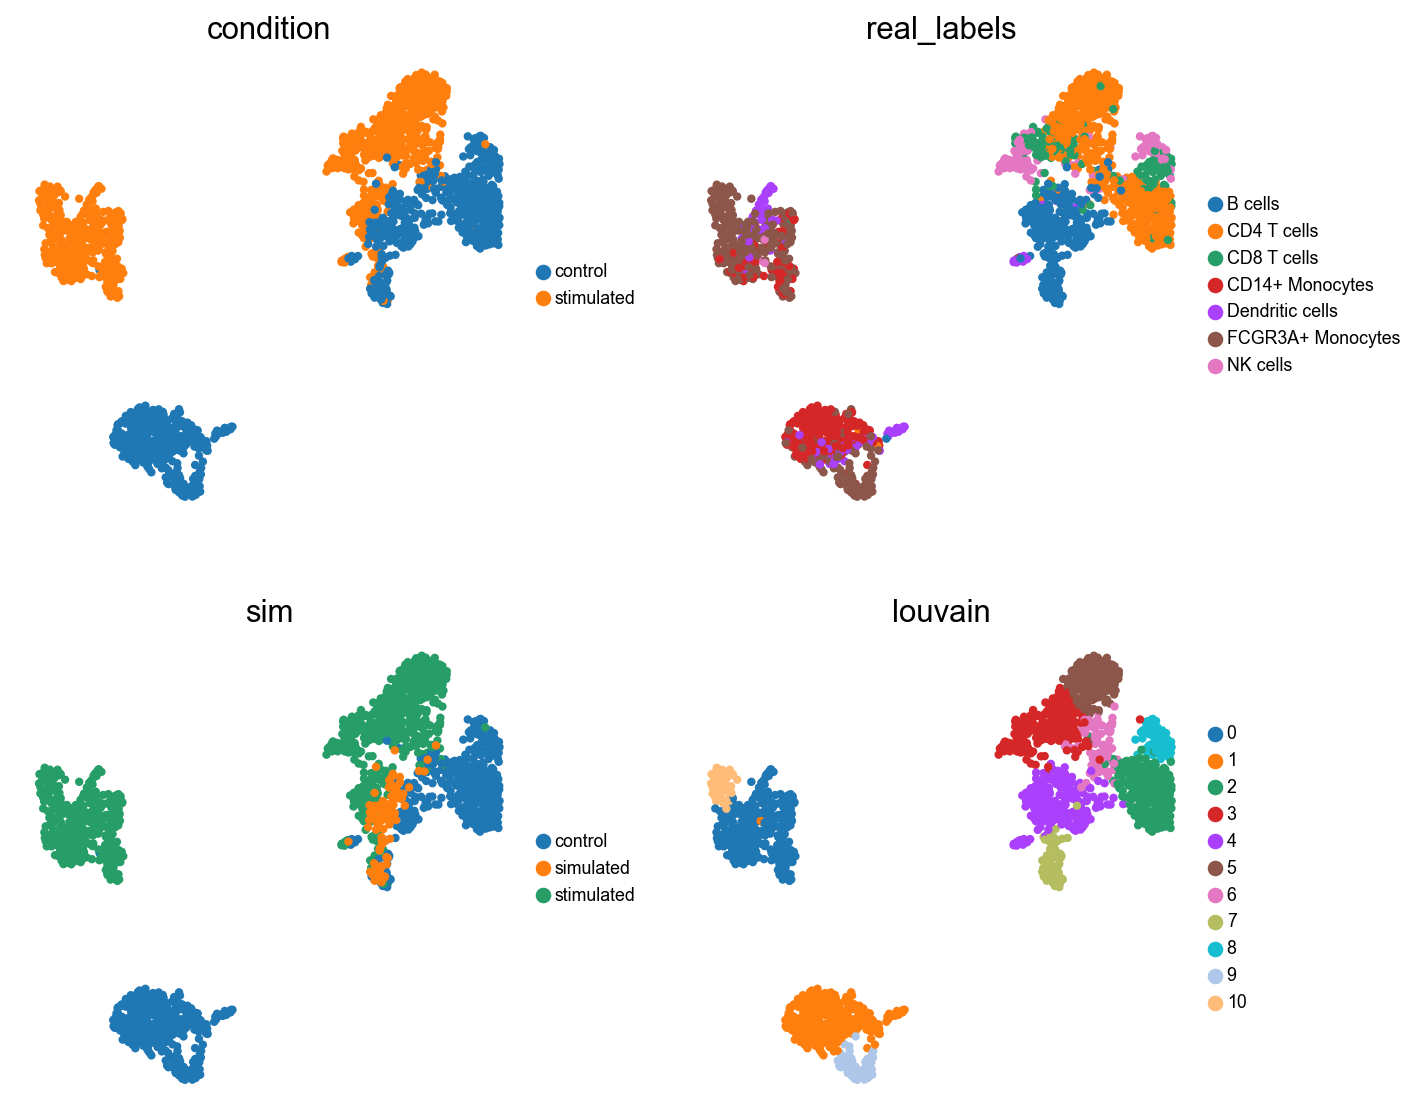

In [79]:
sc.pl.umap(xdata,
           color=[
               "condition",
               "real_labels",
               "sim",
               "louvain",
               ], 
        frameon=False,
        #legend_loc='on data',
        legend_fontsize=8,
        ncols=2,
        #color_map="magma",
        )

In [80]:
bCellsControlData = test_data[ctrlMaerker & bCellMarker].detach()
bCellsStimData = test_data[(~ctrlMaerker) & bCellMarker].detach()
bCellSimStimData = simOutput['rec'].detach().abs() 

In [83]:
stats.linregress(
    #bCellsControlData.mean(0),
    bCellsStimData.mean(0),
    bCellSimStimData.mean(0),
)

LinregressResult(slope=0.9128166490131949, intercept=0.008305120118673348, rvalue=0.9611853216864259, pvalue=0.0, stderr=0.003132180390010396, intercept_stderr=0.0005854512573336184)

In [84]:
stats.linregress(
    bCellsControlData.mean(0),
    #bCellsStimData.mean(0),
    bCellSimStimData.mean(0),
)


LinregressResult(slope=0.9471417289467974, intercept=0.00526348275881823, rvalue=0.9559030563252533, pvalue=0.0, stderr=0.003478500414363831, intercept_stderr=0.000627054330850822)

In [85]:
stats.linregress(
    bCellsControlData.mean(0),
    bCellsStimData.mean(0),
    #bCellSimStimData.mean(0),
)


LinregressResult(slope=0.9318769787765108, intercept=0.002876564465809993, rvalue=0.8931695007474775, pvalue=0.0, stderr=0.0056089311346659175, intercept_stderr=0.0010110979274037281)

In [91]:
ydata = xdata[xdata.obs["real_labels"] == "B cells"].copy()
ydata.obs["sim"]

index
TCCCGAACCGTTGA-1-stimulated-0    stimulated
GATTCGGACGATAC-1-stimulated-0    stimulated
CATTGTTGACGGTT-1-stimulated-0    stimulated
CCAAAGTGCGCTAA-1-stimulated-0    stimulated
CATCAGGAGTATCG-1-stimulated-0    stimulated
                                    ...    
CACATACTCTGCTC-1-control-0-1      simulated
CGTCCATGTCCCGT-1-control-0-1      simulated
ATGATATGCGAGAG-1-control-0-1      simulated
ATCACACTGTTGCA-1-control-0-1      simulated
ACACGAACGCTGTA-1-control-0-1      simulated
Name: sim, Length: 308, dtype: category
Categories (3, object): ['control', 'simulated', 'stimulated']

In [92]:
sc.tl.rank_genes_groups(ydata, groupby="sim", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


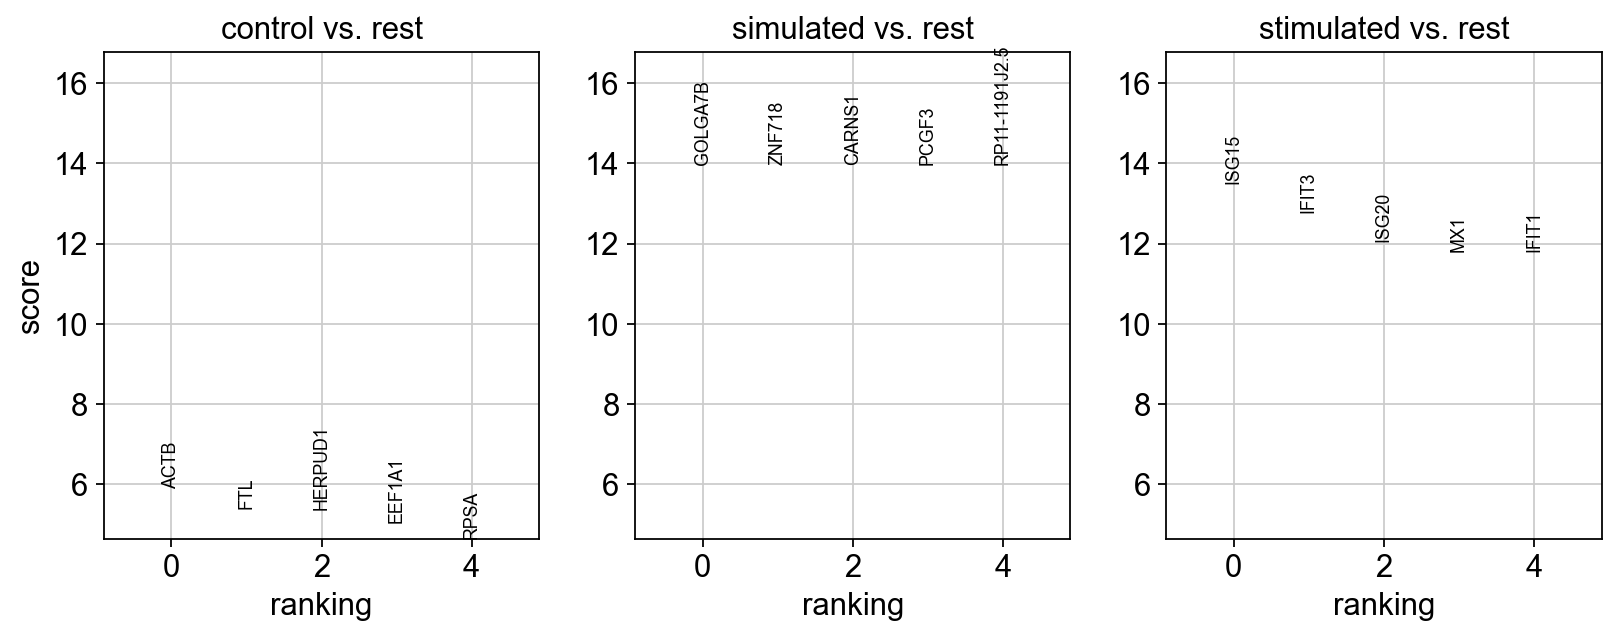

In [93]:
sc.pl.rank_genes_groups(ydata, n_genes=5, cmap="viridis",)

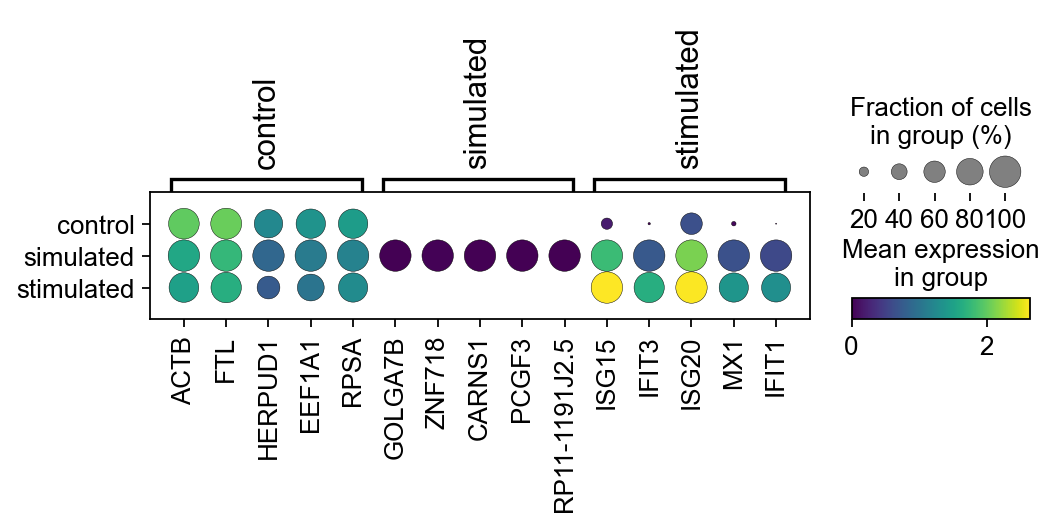

In [97]:
sc.pl.rank_genes_groups_dotplot(ydata, n_genes=5, cmap="viridis", dendrogram=False,)

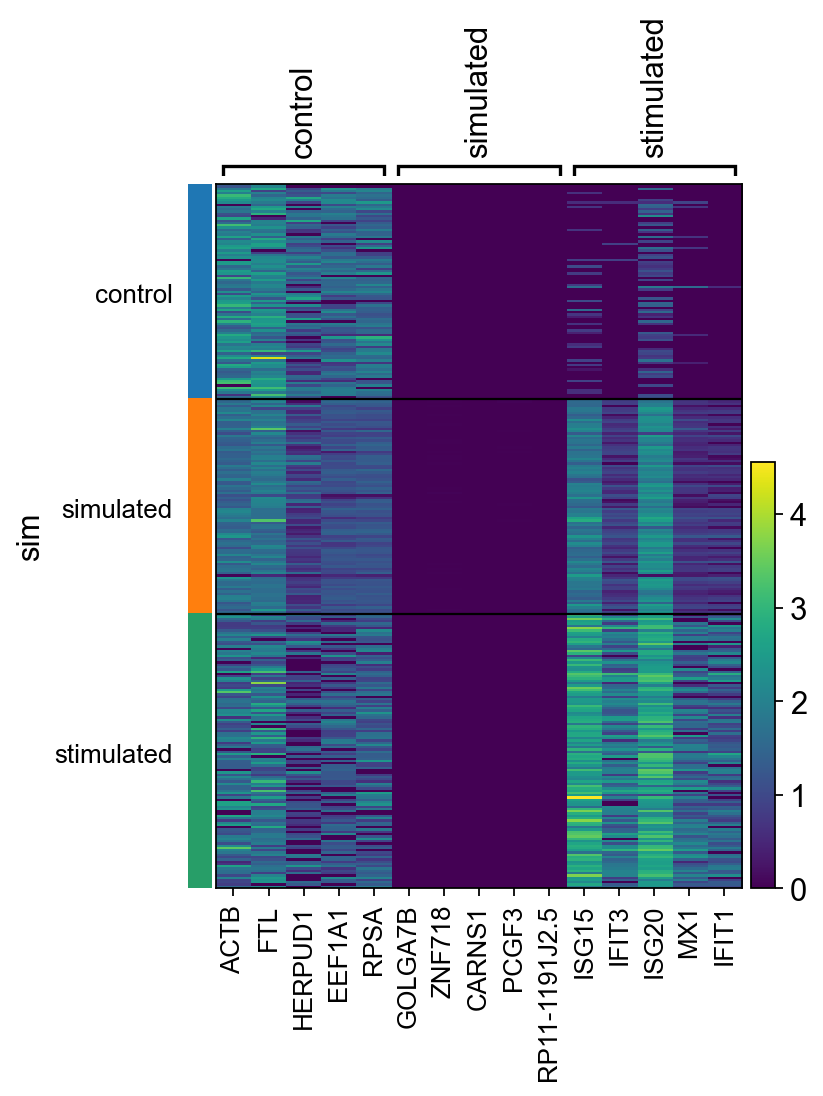

In [100]:
sc.pl.rank_genes_groups_heatmap(ydata, n_genes=5, cmap="viridis", dendrogram=False,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


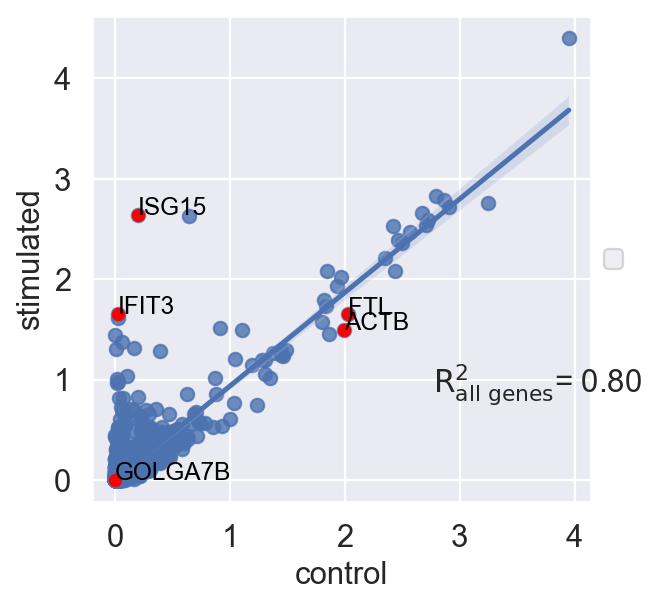

0.7977517425926809

In [135]:
reload(ut)
#ut.reg_mean_plot(ydata[ydata.obs["sim"]  != "simulated"], show=True, condition_key="sim")
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "control", "y" : "stimulated"},
                 labels={"x" : "control", "y" : "stimulated"},
                gene_list=["ACTB", "FTL","ISG15","IFIT3","GOLGA7B",],
                           )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


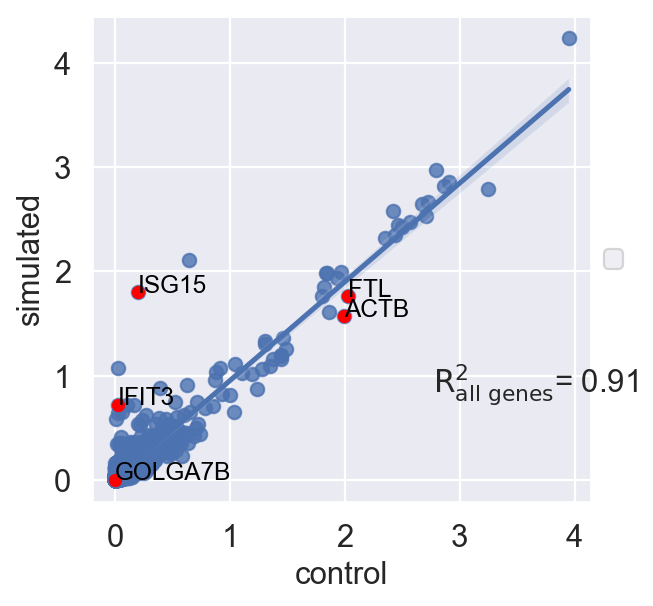

0.9137506541350242

In [136]:
#ut.reg_mean_plot(ydata[ydata.obs["sim"]  != "control"], show=True, condition_key="sim" )
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 labels={"x" : "control", "y" : "simulated"},
                 axis_keys={"x" : "control", "y" : "simulated"}, )
                gene_list=["ACTB", "FTL","ISG15","IFIT3","GOLGA7B",],

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


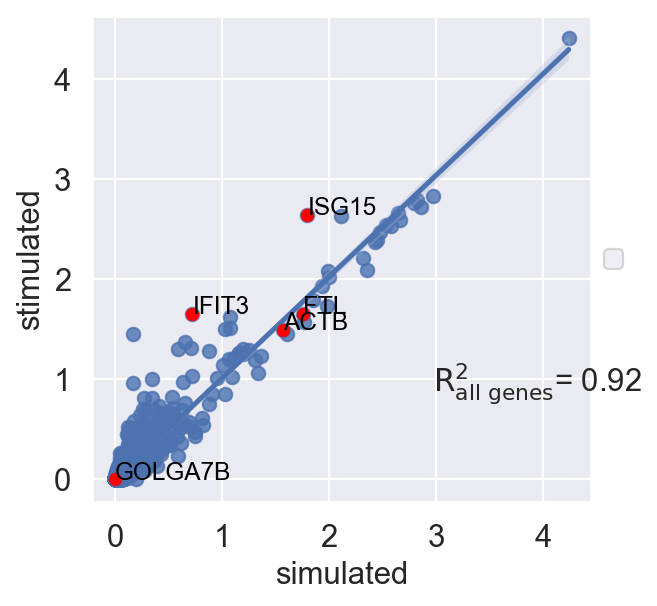

0.9238772139067867

In [137]:
#ut.reg_mean_plot(ydata[ydata.obs["sim"]  != "stimulated"], show=True, )
ut.reg_mean_plot(ydata, show=True, condition_key="sim",
                 axis_keys={"x" : "simulated", "y" : "stimulated",},
                 labels={"x" : "simulated", "y" : "stimulated"},
                gene_list=["ACTB", "FTL","ISG15","IFIT3","GOLGA7B",],
                )

In [138]:
# now we want to generate synthetic data of stimulated/control B-cells and compare with experimental data
test_enc_labels.classes_

array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
       'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells'], dtype=object)

In [199]:
#w = torch.randn(80, model.nw)
#bdata.obsm["w"].mean(0)
#bdata.obsm["w"].var(0)
#w = bdata.obsm["w"].mean(0, keepdims=True,) + torch.randn(80, model.nw) * bdata.obsm["w"].std(0, keepdims=True,)
w = bdata.obsm["w"].mean(0,) + torch.randn(80, model.nw).numpy() * bdata.obsm["w"].std(0,)
c = torch.zeros(80,2)
c[:40,0] = 1
c[40:,1] = 1
#c
w.mean()
w.var()
w.shape
w = torch.tensor(w)

In [200]:
# B cells is category=0, take only the mu part from the last dim
z = model.Pz(
    torch.cat([w,c], dim=1),)[:,0,:model.nz]
rec = model.Px(
    torch.cat([z,c], dim=1),)
rec.shape

torch.Size([80, 7000])

In [201]:
ddata = sc.AnnData(
    X = rec.detach().numpy(),
    obs = {
        "condition" : 40*["control"] + 40*["stimulated"],
        "sim" : 40*["gen_control"] + 40*["gen_stimulated"],
        "real_labels" : 80 * ["B cells"],
    },
    obsm = {
        "z" : z.detach().numpy(),
        "w" : w.detach().numpy(),
    },
    var = {
        "var_names" : bdata.var_names,
    }
)
        

In [202]:
bdata.obs
ddata.obs

condition             sim real_labels
0      control     gen_control     B cells
1      control     gen_control     B cells
2      control     gen_control     B cells
3      control     gen_control     B cells
4      control     gen_control     B cells
..         ...             ...         ...
75  stimulated  gen_stimulated     B cells
76  stimulated  gen_stimulated     B cells
77  stimulated  gen_stimulated     B cells
78  stimulated  gen_stimulated     B cells
79  stimulated  gen_stimulated     B cells

[80 rows x 3 columns]

In [203]:
xxdata = ad.concat([bdata, ddata], label="set", join="inner",)
#xxdata = ad.concat([adata, ddata], label="set", join="inner",)
xxdata.var_names_make_unique()
xxdata.obs_names_make_unique()
xxdata

AnnData object with n_obs × n_vars = 2080 × 7000
    obs: 'condition', 'real_labels', 'sim', 'set'
    obsm: 'z', 'w'

In [204]:
#sc.pp.neighbors(xxdata, use_rep="z",)
sc.pp.pca(xxdata,)
sc.pp.neighbors(xxdata, )
sc.tl.umap(xxdata,)
sc.tl.louvain(xxdata,)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'real_labels' as categorical
/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed

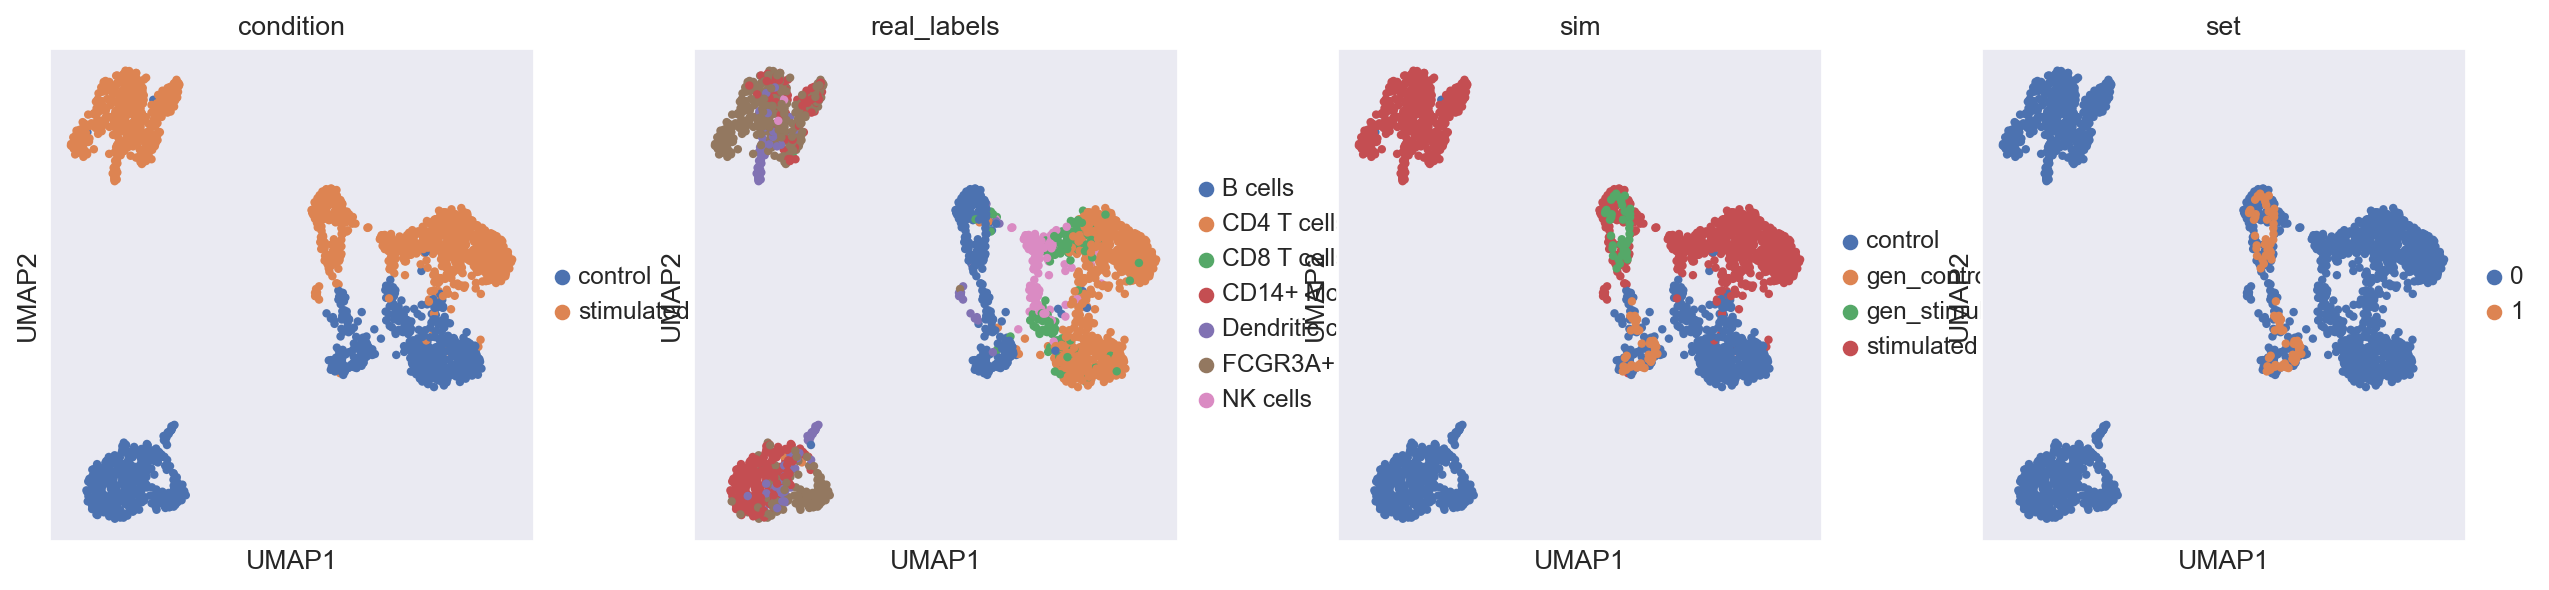

In [205]:
sc.pl.umap(xxdata,
           color=[
               "condition",
               "real_labels",
               "sim",
               "set",
           ],
          )

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


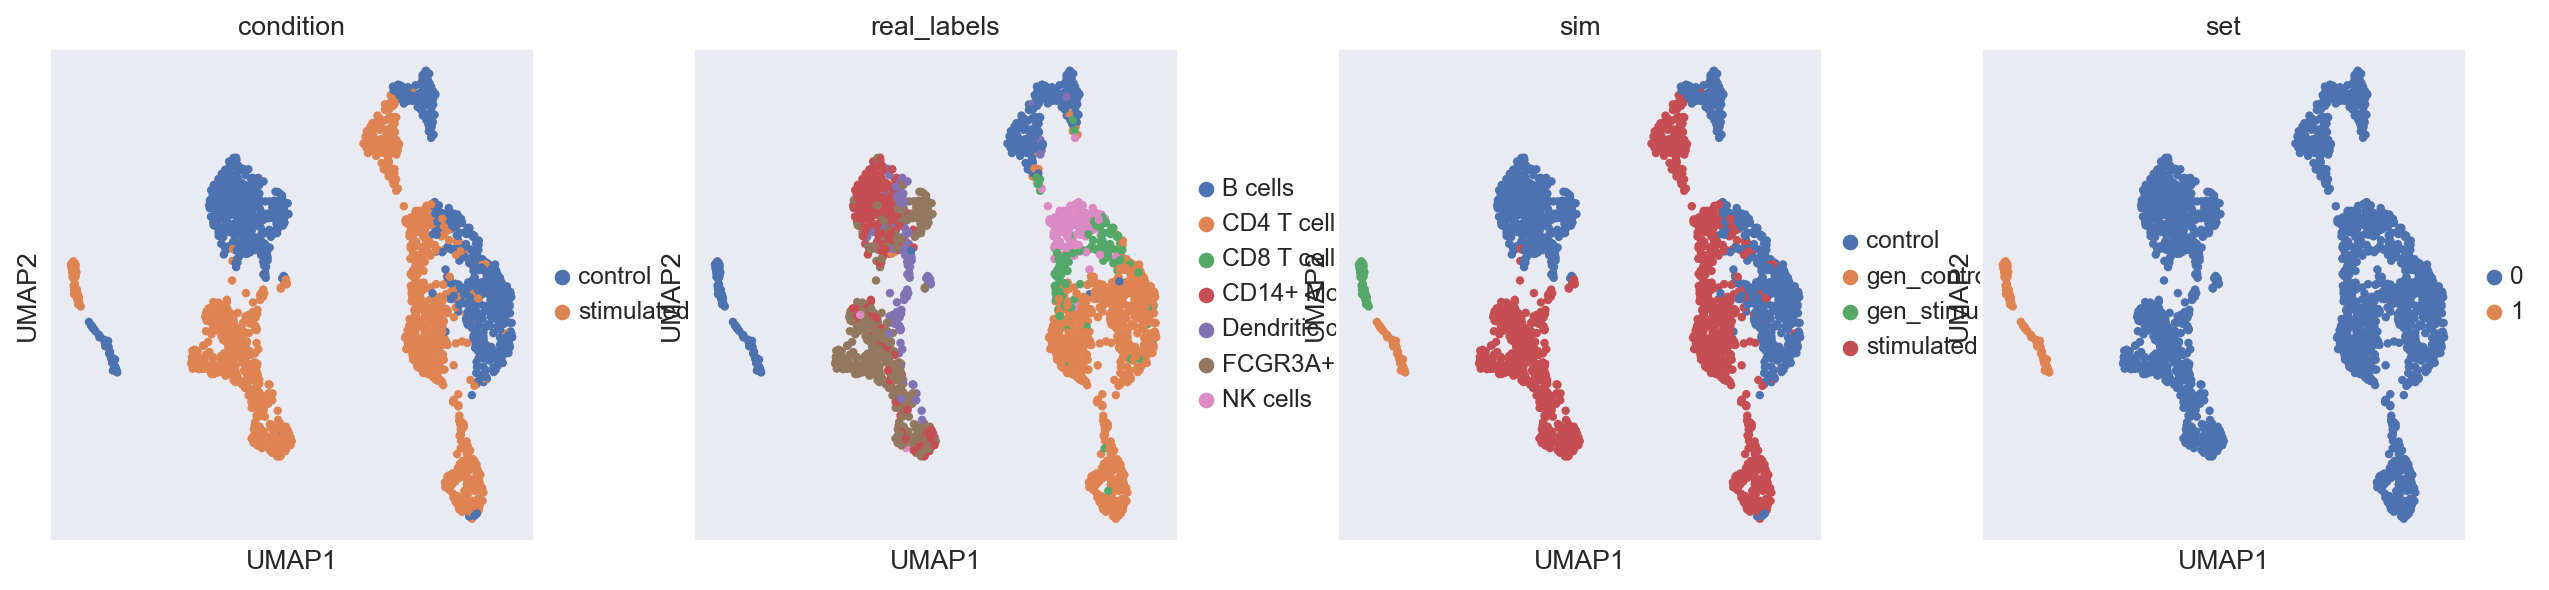

In [206]:
#sc.pp.pca(xxdata,)
#sc.pp.neighbors(xxdata, )
sc.pp.neighbors(xxdata, use_rep="z",)
sc.tl.umap(xxdata,)
sc.tl.louvain(xxdata,)
sc.pl.umap(xxdata,
           color=[
               "condition",
               "real_labels",
               "sim",
               "set",
           ],
          )

In [207]:
bdata.obsm["w"].mean(-1)
bdata.obsm["w"].var(-1)
bdata.obsm["w"].var(-1).shape
bdata.obsm["w"].mean()
bdata.obsm["w"].var()
bdata.obsm["w"].shape
bdata.obsm["w"].mean(0)
bdata.obsm["w"].var(0)[:]

array([1.0459789 , 0.9644925 , 1.0028398 , 1.0525982 , 1.0475392 ,
       0.9888235 , 1.0073751 , 0.95202506, 1.0479954 , 1.0082961 ],
      dtype=float32)